# Imports and custom package

Import necessary packages

In [1]:
import os
import sys
import pickle
import importlib
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib

import matplotlib.pyplot as plt
# keep matplotlib interactive
%matplotlib notebook
# use ggplot style
plt.style.use('ggplot')

# expose the 'utils' directory as one where we can import modules
# here utils is one directory up from notebooks
utils_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(utils_dir)

# import custom package fextract made for this project
from utils import fextract as ft

# Load features and targets

In [2]:
# create relevant directories
features_dir = os.path.join(os.pardir, 'data', 'processed', 'Onehotfeatures.pkl')
target_dir = os.path.join(os.pardir, 'data', 'processed', 'target.npy')

# load features
features = pickle.load( open( features_dir, 'rb' ) )

# load associated targets
y = np.load(target_dir)

Choose features and prepare data for scikit-learn prototyping

In [3]:
# keep features of interest
imp_feature = ['User_ID', 'Product_ID', 'Gender_Prod_cat123']
# imp_feature = ['User_ID', 'Product_ID', 'Gender', 'Prod_cat123']
# only keep corresponding features
X_features = tuple(features.get(f, 'Feature not present') for f in imp_feature)

In [4]:
X = hstack( X_features )
X.shape, type(X)

((550071, 9996), scipy.sparse.coo.coo_matrix)

# Gradient Boosting Regression Tree (GBRT)

As opposed to Random Forest, GBRT does `'best'` split for each node of each tree. `'best'` finds the optimal feature and threshold for each new node. However, we have control over the sample size (number of training instances to include at each new tree) which will add randomness to this sequential process (see '`subsample`')

There is a `'learning_rate'` to control quantity of residuals to cancel out from one tree to another.
`'warm_start'` is here so that when fit() is called in a loop, it doesn't start over. Instead, it builds up from the last tree created.

In summary, here are the hyperparameters:
1. **`n_estimators`**, number of sequential trees, should be higher if learning rate low (generally tuned by cv)
2. **`learning_rate`**, controls the amount of change in your target. The lower the better. Default value of 0.1 is a good start
3. **`subsample`**, select randomly a fraction of training samples for each tree. It trades a higher bias for a lower variance. This is called Stochastic Gradient Boosting. Typical value is 0.8

[Sklearn Gradient Boosting Regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) 

Split data

In [5]:
# train/ val split, test_size=0.25 by default
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)

Create GBRT and run it in a loop to find the optimal number of estimators

In [6]:
# Gradient Boosting for decision trees where residuals are used as a target for the next tree
# init parameter: input a model to get started, initial tree only (Optional)
gb_regtree = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.01,\
                                       warm_start = True, subsample = 0.8,\
                                       min_samples_leaf = 5, max_depth = 925,\
                                       random_state = 29, verbose = 1)
# run the entire 
# gb_regtree.fit(X,y)

# monitor the error
min_val_error = float('Inf')
# counter when error goes up again
error_going_up = 0
# must use the same train/val data, split just once
# create up to 500 trees, TO RERUN WITH 1000
for n_repetition in range(1, 1000):
    # set number of estimators
    gb_regtree.n_estimators = n_repetition

    # train model
    gb_regtree.fit(X_train, y_train)
    
    # predict on validation set
    y_val_pred = gb_regtree.predict(X_val)
    
    # assess error (MSE)
    val_score = mean_squared_error(y_val, y_val_pred)
    
    # decide to continue or stop loop
    if val_score < min_val_error:
        min_val_error = val_score
        error_going_up = 0
    else:
        error_going_up += 1
        # stop when error is higher than minimum 5 times in a row
        if error_going_up == 5:
            break

      Iter       Train Loss      OOB Improve   Remaining Time 
         1    24871577.8490      364503.2400            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         2    24509293.9233      357200.3109            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         3    24154177.5463      350072.2608            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         4    23806099.7212      343108.9481            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         5    23464874.9950      336248.0165            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         6    23130387.5711      329492.8753            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         7    22802570.9149      322947.3485            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         8    22481180.4495      316529.8244            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
        67    11413602.9050       97020.4074            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        68    11314930.0910       94867.8674            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        69    11218031.4205       93086.1151            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        70    11123141.3477       91242.6862            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        71    11029879.2281       89598.3240            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        72    10938525.1866       87620.3453            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        73    10848852.0344       85931.0229            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        74    10760956.8947       84127.0316            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
       133     7632914.4486       26866.2810            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       134     7603025.9069       26712.3208            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       135     7573882.9379       25820.9049            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       136     7545062.5261       25285.8959            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       137     7516748.4226       25262.7399            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       138     7489087.9020       24565.1342            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       139     7461896.1344       24043.2180            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       140     7434902.2661       23864.5798            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
       199     6420838.7044        8192.0696            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       200     6410241.4398        7907.0359            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       201     6399619.6079        7817.3966            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       202     6389085.5395        7713.6384            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       203     6378746.7375        7538.6334            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       204     6368739.7630        7208.0432            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       205     6358621.6632        7344.8929            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       206     6348664.6027        7198.3427            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
       265     5933282.1647        2530.3003            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       266     5928359.3646        2561.9237            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       267     5923431.9820        2622.1216            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       268     5918620.5054        2492.1077            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       269     5913818.3795        2555.2254            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       270     5909033.0094        2359.2920            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       271     5904243.1561        2478.8911            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       272     5899531.8749        2414.1293            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
       331     5668444.4710        1427.7501            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       332     5665165.6594        1432.7243            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       333     5661745.3905        1650.4030            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       334     5658534.0928        1299.3589            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       335     5655356.6172        1429.1285            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       336     5652248.2281        1213.3038            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       337     5649001.9484        1466.1738            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       338     5645777.0041        1278.3915            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
       397     5468365.3457        1196.7421            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       398     5466211.2020         864.2162            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       399     5463734.1630        1405.9342            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       400     5461513.4716        1035.2468            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       401     5459052.6433        1631.3168            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       402     5456578.4213        1751.3211            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       403     5454475.0242         821.7208            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       404     5452065.8800        1612.2554            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
       463     5338895.9704         989.3945            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       464     5337222.1846         629.4151            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       465     5335686.6432         942.3786            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       466     5334032.4972         586.2416            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       467     5332582.8996         949.0518            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       468     5331003.8006         382.5778            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       469     5329375.6245         523.5920            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       470     5327941.3029         848.7404            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
       529     5250176.3067         330.4238            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       530     5249046.9735         433.6320            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       531     5247925.0390         312.0332            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       532     5246828.1809         249.9851            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       533     5245717.2895         442.2321            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       534     5244651.0575         357.1632            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       535     5243544.3509         318.3415            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       536     5242380.3727         277.8247            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
       595     5185363.1833         254.3516            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       596     5184547.0653         220.9151            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       597     5183649.0265         192.5552            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       598     5182751.1409         273.0366            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       599     5181949.0030         286.9912            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       600     5181220.4973         254.4395            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       601     5180386.3895         151.2439            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       602     5179596.7011         278.3163            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
       661     5136818.4185         210.7715            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       662     5136137.3105         183.3328            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       663     5135538.2808         210.7835            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       664     5134880.7905         165.5230            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       665     5134279.0626         144.7836            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       666     5133669.8884         144.2116            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       667     5133022.0916         153.0104            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       668     5132428.6581         119.4652            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
       727     5097621.0248         126.6058            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       728     5097099.6874         102.7195            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       729     5096586.8913         131.1712            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       730     5096020.4590          95.7833            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       731     5095490.5714          90.5794            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       732     5094929.0831         134.5551            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       733     5094412.0688          79.5141            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       734     5093960.5386          72.5264            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
       793     5064882.9440          67.9095            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       794     5064399.5374          56.6613            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       795     5063937.3886          99.2985            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       796     5063497.7344          37.4444            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       797     5063036.0833          61.6827            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       798     5062619.8479          25.2458            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       799     5062125.1437          -1.9230            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       800     5061682.9841          78.1252            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
       859     5035277.1538          17.4502            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       860     5034874.0827          42.5082            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       861     5034477.0962          -8.2190            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       862     5034073.6870         -21.5056            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       863     5033640.8057           2.3610            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       864     5033241.0571         -42.8892            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       865     5032815.9522          48.3870            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       866     5032437.2053          -5.1624            0.00s


Performance result on cross-validation (1 fold here)

In [7]:
# result after optimization
print('MSE (mean cross-validation) = {:.4f}'.format(min_val_error) )
print('RMSE (mean cross-validation) = {:.4f}'.format(np.sqrt(min_val_error)) )

# Recent results:
# RMSE (mean cross-validation) = 2596.6717, learning_rate=0.1 and subsample = 0.25
# RMSE (mean cross-validation) = 2528.0135, learning_rate=0.05 and subsample = 0.8

MSE (mean cross-validation) = 6382542.9500
RMSE (mean cross-validation) = 2526.3695


Save model

In [8]:
# SAVE MODEL
joblib.dump(gb_regtree, './../models/GBRT_Model.pkl')

# example to load model
# gb_regtree = joblib.load('GBRT_Model.pkl')

['./../models/GBRT_Model.pkl']

Plot the error as a function of number of estimators. Error should flatten out toward the end.

<IPython.core.display.Javascript object>


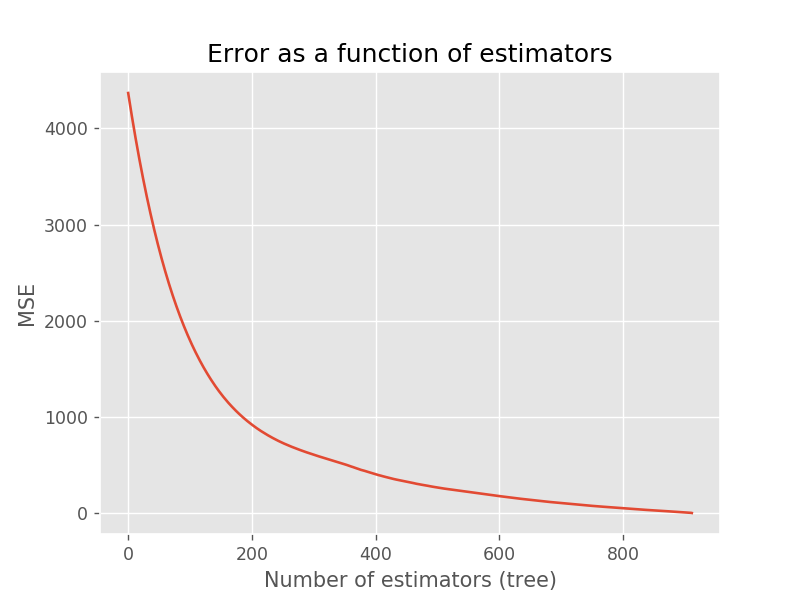

Text(0,0.5,'MSE')

In [9]:
# recover all cross validation errors
errors_val = [np.sqrt(mean_squared_error(y_s, y_val_pred)) for y_s in gb_regtree.staged_predict(X_val)]

# error vs number of trees (iteration)
_, axgbrt = plt.subplots()
axgbrt.plot(range(gb_regtree.n_estimators),errors_val)
# add title and axes labels
axgbrt.set_title('Error as a function of estimators')
axgbrt.set_xlabel('Number of estimators (tree)')
axgbrt.set_ylabel('MSE')

# Run model on test set

Read test set in memory, recover encoders from file and derive one-hot encoded features

In [10]:
test_dir = os.path.join(os.pardir, 'data', 'raw','test_HujdGe7', 'test.csv')
df_test = pd.read_csv(test_dir)

# Load encoders
OneHotencoder_dir = os.path.join(os.pardir, 'data', 'Onehotencoders.pkl')
encoders = pickle.load( open( OneHotencoder_dir, 'rb' ) )
Catencoder_dir = os.path.join(os.pardir, 'data', 'Category_encoders.pkl')
catcoders = pickle.load( open( Catencoder_dir, 'rb' ) )

# reload is necessary if one makes changes in fextract. Indeed modules are loaded once only, this forces a reload.
importlib.reload(ft)

# get one-hot encoded features and their names
features_test = ft.prepare_Data(df_test, (catcoders, encoders))

Select necessary features (must match your feature model obviously)

In [11]:
X_features_test = tuple(features_test.get(f, 'Feature not present') for f in imp_feature)
X_test = hstack( X_features_test )
# check shape
X_test.shape

(233599, 9996)

Make predictions and save them to file

In [12]:
y_pred_test = gb_regtree.predict(X_test)

# format result save to csv for submission
df_results = df_test.loc[:,('User_ID','Product_ID')]
df_results['Purchase'] = y_pred_test.reshape(-1,1)
submission_dir = os.path.join(os.pardir,'submissions', 'Submission_GBRT.csv')
df_results.to_csv(submission_dir, index=False)